In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

### 1. Загрузка  и исследование данных

In [2]:
df = pd.read_csv("forestfires.csv")

df.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
df.shape

(517, 13)

In [4]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


### 2. Проверка на наличие пропущенных значений.

In [6]:
df.isna().sum().sum()

0

Таковых не наблюдается.

### 3. Исследование распределения признаков и откликов

In [7]:
X = df.drop(columns = 'area')
y = df['area']

cat_columns = X.select_dtypes(include = 'object').columns.tolist()
num_columns = X.select_dtypes(exclude = 'object').columns.tolist()

cat_columns, num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

In [8]:
my_style = {"grid.color": "0.95", 'lines.linewidth' : 1.5}
sns.set_theme(context = 'talk', style = 'whitegrid', rc = my_style)

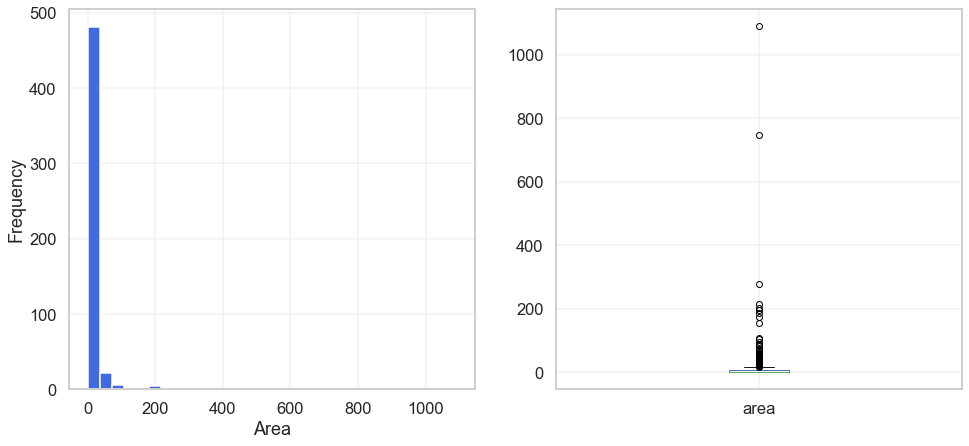

In [9]:
plt.figure(figsize = (16, 7))
plt.subplot(121)
df['area'].plot.hist(bins = 30, color = 'royalblue')
plt.xlabel('Area')
plt.savefig('area_distribution.pdf', bbox_inches = 'tight')

plt.subplot(122)
df['area'].plot.box();

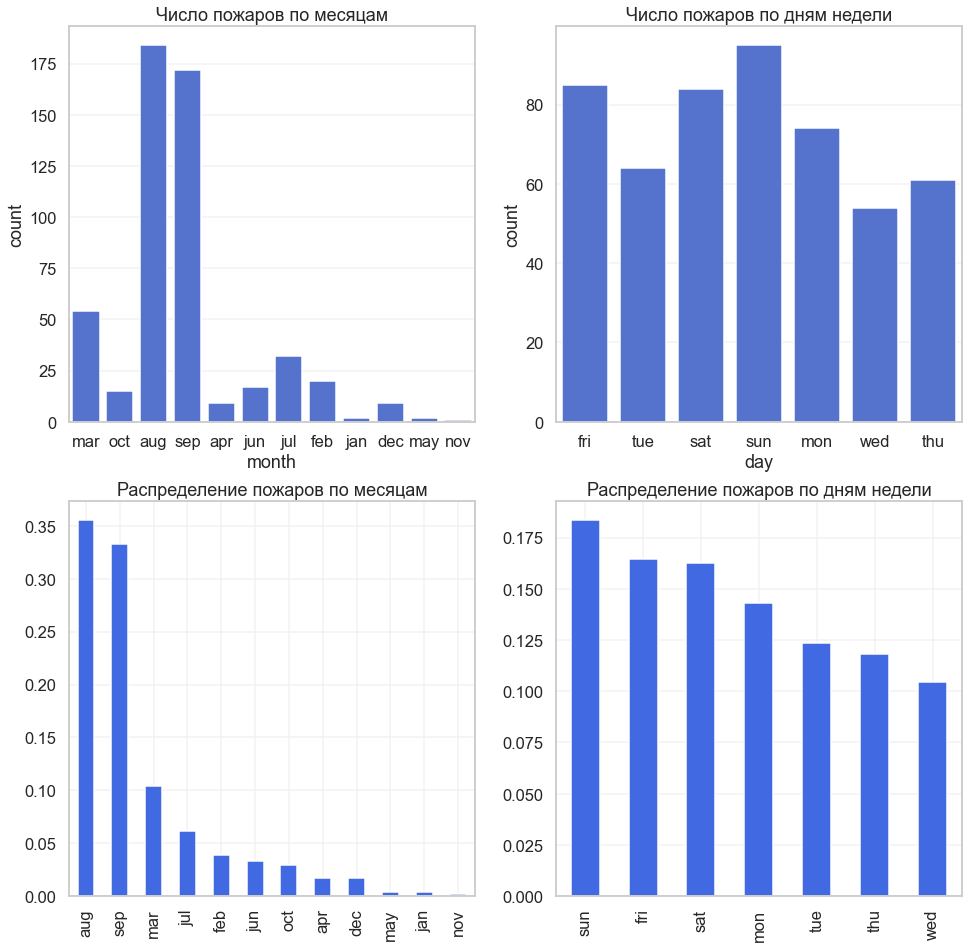

In [10]:
plt.figure(figsize = (16, 16))

plt.subplot(2, 2, 1)
sns.countplot(x = "month", data = df, color = 'royalblue')
plt.title('Число пожаров по месяцам')

plt.subplot(2, 2, 2)
sns.countplot(x = "day", data = df, color = 'royalblue')
plt.title('Число пожаров по дням недели')

plt.subplot(2, 2, 3)
df['month'].value_counts(normalize=True).plot.bar(color = 'royalblue')
plt.title('Распределение пожаров по месяцам')

plt.subplot(2, 2, 4)
df['day'].value_counts(normalize=True).plot.bar(color = 'royalblue')
plt.title('Распределение пожаров по дням недели');

plt.savefig('cat_features.pdf', bbox_inches = 'tight')

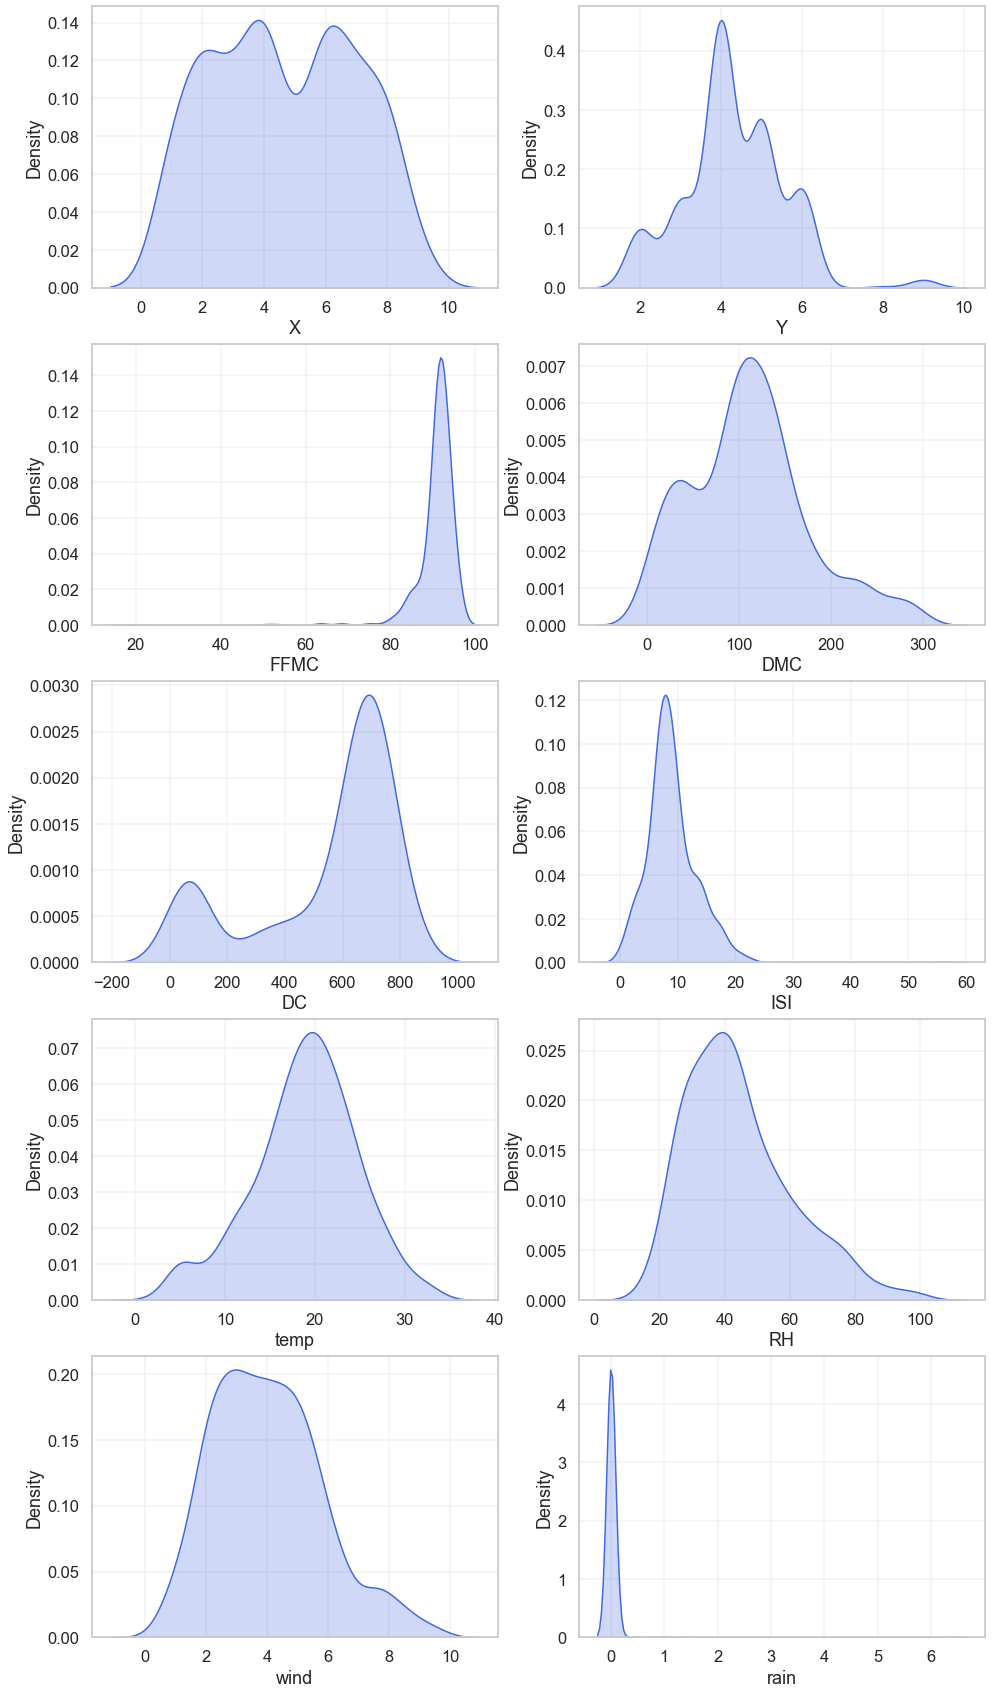

In [11]:
plt.figure(figsize = (16, 30))

for i, col in enumerate(num_columns, 1):
    plt.subplot(5,2,i)
    sns.kdeplot(df[col], color = 'royalblue', shade = True)

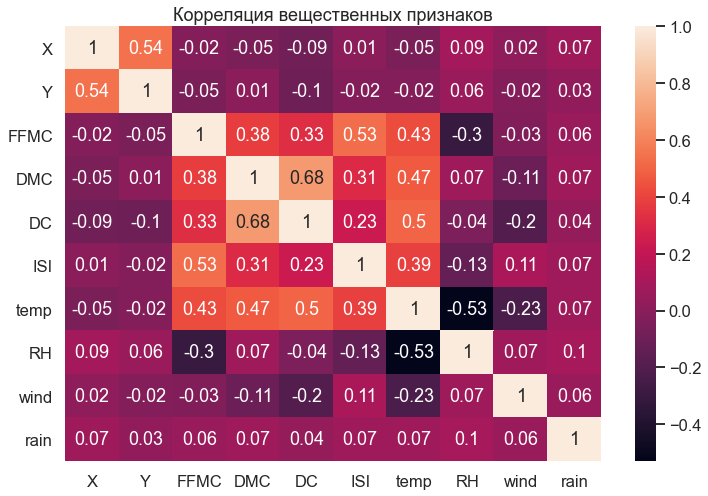

In [12]:
plt.figure(figsize = (12, 8))
sns.heatmap(np.round(df[num_columns].corr(), 2), annot = True)
plt.title('Корреляция вещественных признаков')

plt.savefig('num_features_corr.pdf', bbox_inches = 'tight')

### 4. Подготовка данных к созданию модели

В данных наблюдается несколько выбросов, поэтому при построении линейной модели имеет смысл избавиться от них.

In [13]:
df_cut = df[df['area'] < 250]

#### а) One-Hot Encoding категориальных признаков:

In [14]:
df_encoded_oh = pd.get_dummies(df_cut, columns = cat_columns)

In [15]:
df_encoded_oh

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,1,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,1,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,1,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
X_oh = df_encoded_oh.drop('area', 1)
y_oh = df_encoded_oh['area']

In [17]:
cat_columns_oh = X_oh.select_dtypes(include = 'uint8').columns.tolist()
num_columns_oh = X_oh.select_dtypes(exclude = 'uint8').columns.tolist()

#### б) Категориальные признаки как порядковые:

In [18]:
df_encoded = pd.DataFrame(df_cut.copy())

In [19]:
df_encoded['month'].replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'), (1,2,3,4,5,6,7,8,9,10,11,12), inplace = True)
df_encoded['day'].replace(('mon','tue','wed','thu','fri','sat','sun'), (1,2,3,4,5,6,7), inplace = True)

In [20]:
df_encoded

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,6,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [21]:
X = df_encoded.drop('area', 1)
y = df_encoded['area']

In [22]:
cat_columns = df.select_dtypes(include = 'object').columns.tolist()
num_columns = X.select_dtypes(exclude = 'object').columns.tolist()

### 5. МНК

Линейная регрессия без регуляризации:

$$X = X_{m \times n}, \ y = y_{m \times 1}, \ w = w_{n \times 1},$$

$$Q(a) = \dfrac{1}{m} \lVert X w - y \rVert^2,$$

$$w^* = (X^T X)^{-1} X^T y.$$

In [23]:
def w_opt(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def MSE(X, y, w):
    return (np.linalg.norm(X.dot(w) - y) ** 2) / X.shape[0]

In [24]:
print('One-Hot encoding:')
print('MSE =', round(MSE(X_oh, y_oh, w_opt(X_oh, y_oh)), 2))
print('RMSE =', round(np.sqrt(MSE(X_oh, y_oh, w_opt(X_oh, y_oh))), 2))

One-Hot encoding:
MSE = 7094.7
RMSE = 84.23


In [25]:
print('Категориальные как порядковые:')
print('MSE =', round(MSE(X, y, w_opt(X, y)), 2))
print('RMSE =', round(np.sqrt(MSE(X, y, w_opt(X, y))), 2))

Категориальные как порядковые:
MSE = 593.16
RMSE = 24.35


### 6. МНК с регуляризацией

Линейная регрессия с $L_2$ регуляризацией (регуляризацией Тихонова):

$$X = X_{m \times n}, \ Y = Y_{m \times 1}, \ w = w_{n \times 1},$$

$$Q(a) = \dfrac{1}{m} \lVert X w - Y \rVert^2 + \alpha \lVert w \rVert^2,$$

$$w^* = (X^T X + \alpha E_n)^{-1} X^T Y.$$

In [26]:
def w_opt_reg(X, y, alpha):
    return np.linalg.inv(X.T.dot(X) + (alpha * np.identity(X.shape[1]))).dot(X.T).dot(y)

def MSE_reg(X, y, w, alpha):
    return ((np.linalg.norm(X.dot(w) - y) ** 2) / X.shape[0]) + (alpha * (np.linalg.norm(w) ** 2))

In [27]:
print('One-Hot encoding, alpha = 1:')
print('MSE =', round(MSE_reg(X_oh, y_oh, w_opt_reg(X_oh, y_oh, 1), 1), 2))
print('RMSE =', round(np.sqrt(MSE_reg(X_oh, y_oh, w_opt_reg(X_oh, y_oh, 1), 1)), 2))

One-Hot encoding, alpha = 1:
MSE = 1767.92
RMSE = 42.05


In [28]:
print('Категориальные как порядковые, alpha = 1:')
print('MSE =', round(MSE_reg(X, y, w_opt_reg(X, y, 1), 1), 2))
print('RMSE =', round(np.sqrt(MSE_reg(X, y, w_opt_reg(X, y, 1), 1)), 2))

Категориальные как порядковые, alpha = 1:
MSE = 598.04
RMSE = 24.45


Построим графики зависимости MSE от $\alpha$ на кросс-валидации.

In [29]:
# Возвращает массивы MSEs и Ws в зависимости от alpha, а также лучшее значение alpha и соответствующие веса W
def MSE_L2_CV(X, y, cat_columns, num_columns, alphas, onehot = True, scaled = False, n_splits = 5):
    
    CV = KFold(n_splits, shuffle = True, random_state = 0)
    MSEs = []
    Ws = []
    
    for alpha in alphas:
        
        MSE_alpha = []
        Ws_alpha = []
        
        for train_index, test_index in CV.split(X):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            if scaled == True:
                
                scaler = StandardScaler()
                
                if onehot == True:
                    
                    X_train_num, X_test_num = X_train[num_columns], X_test[num_columns]
                    X_train_cat, X_test_cat = X_train[cat_columns], X_test[cat_columns]
                    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num),\
                                                      index = X_train_num.index, columns = X_train_num.columns)
                    X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num),\
                                                     index = X_test_num.index, columns = X_test_num.columns)
                    X_train_scaled = pd.DataFrame(np.hstack((X_train_num_scaled, X_train_cat)),\
                                            index = X_train.index, columns = [*X_train_num_scaled.columns, *X_train_cat.columns])
                    X_test_scaled = pd.DataFrame(np.hstack((X_test_num_scaled, X_test_cat)),\
                                            index = X_test.index, columns = [*X_test_num_scaled.columns, *X_test_cat.columns])
                elif onehot == False:
                    
                    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),\
                                                  index = X_train.index, columns = X_train.columns)
                    X_test_scaled = pd.DataFrame(scaler.transform(X_test),\
                                                 index = X_test.index, columns = X_test.columns)
                
                w = w_opt_reg(X_train_scaled, y_train, alpha)
                MSE = MSE_reg(X_test_scaled, y_test, w, alpha)
                
            elif scaled == False:
                
                w = w_opt_reg(X_train, y_train, alpha)
                MSE = MSE_reg(X_test, y_test, w, alpha)
                
            MSE_alpha.append(MSE)
            Ws_alpha.append(w)
            
        MSEs.append(np.array(MSE_alpha).mean())
        Ws.append(np.mean(np.array(Ws_alpha), axis = 0))
    
    Alpha = alphas[np.argmin(MSEs)]
    MSE = MSEs[np.argmin(MSEs)]
    W = Ws[np.argmin(MSEs)]
    
    return MSEs, Ws, Alpha, MSE, W

In [30]:
# Строит графики зависимостей MSE(alpha) и W(alpha)
def PLOT_L2_CV(X, y, cat_columns, num_columns, alphas, onehot = True, scaled = False, n_splits = 5):
    
    MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X, y, cat_columns, num_columns, alphas, onehot, scaled, n_splits)
    
    plt.figure(figsize = (9, 6))
    
    label = onehot * 'One-Hot Encoding' + (1 - onehot) * 'Ordinal'
    plt.plot(alphas, MSEs, label = label)
    plt.title('График зависимости MSE($\\alpha$)')
    plt.xlabel('$\\alpha$')
    plt.ylabel('MSE')
    plt.legend(loc = 'lower right')
    
    plt.savefig('MSE_plot' + onehot * '_oh' + scaled * '_scaled' + '.pdf', bbox_inches = 'tight')
    
    plt.figure(figsize = (9, 6))

    for coef, feature in zip(np.array(Ws).T, X.columns):
        plt.plot(alphas, coef, label = feature, color = np.random.rand(3))
    
    plt.title('График завимости весов признаков от $\\alpha$')
    plt.xlabel("$\\alpha$")
    plt.ylabel("Feature weight")
    
    plt.savefig('feature_plot' + onehot * '_oh' + scaled * '_scaled' + '.pdf', bbox_inches = 'tight')

**One-Hot encoding**

The best alpha order:  1e-12
The best MSE:  622.91


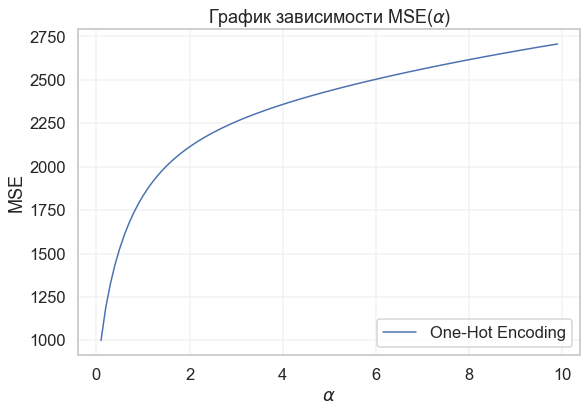

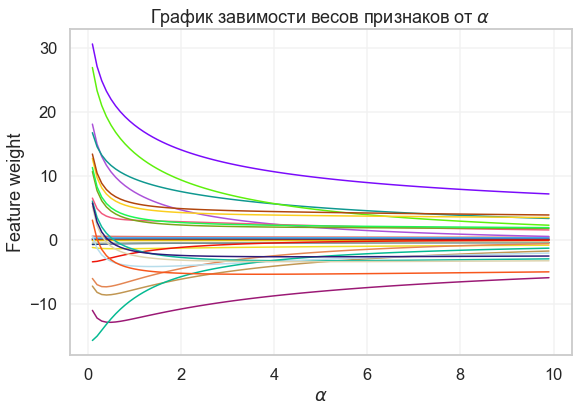

In [31]:
alphas = np.arange(0.1, 10, 0.1)
PLOT_L2_CV(X_oh, y_oh, cat_columns_oh, num_columns_oh, alphas, onehot = True, scaled = False, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_oh, y_oh, cat_columns_oh, num_columns_oh, alphas,\
                                    onehot = True, scaled = False, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

**Категориальные как порядковые**

The best alpha order:  1e-14
The best MSE:  616.5


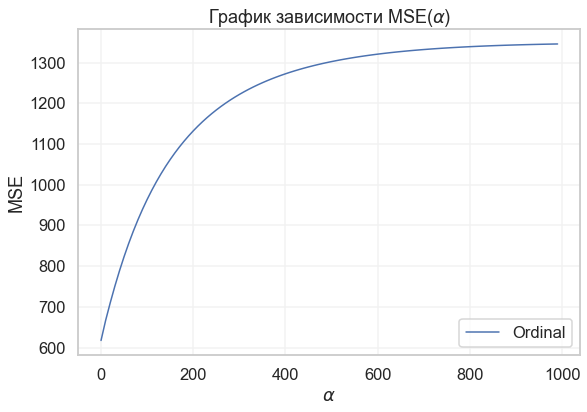

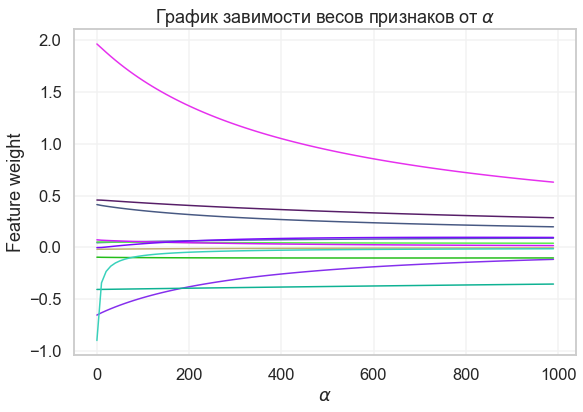

In [32]:
alphas = np.arange(0.1, 1000, 10)
PLOT_L2_CV(X, y, cat_columns, num_columns, alphas, onehot = False, scaled = False, n_splits = 10)

alphas = np.logspace(-16, 16, 33)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X, y, cat_columns, num_columns, alphas,\
                                    onehot = False, scaled = False, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

### 7. Стандартизация

**One-Hot encoding**

The best alpha order:  1e-12
The best MSE:  624.78


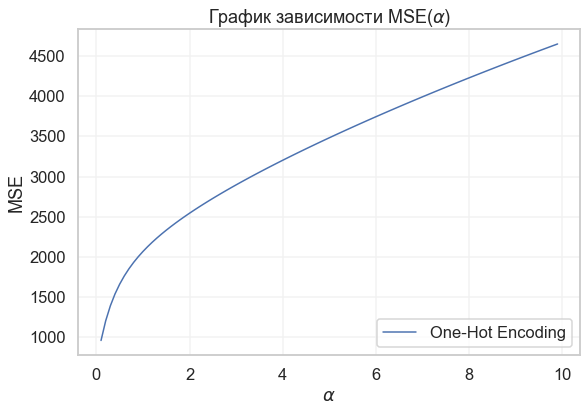

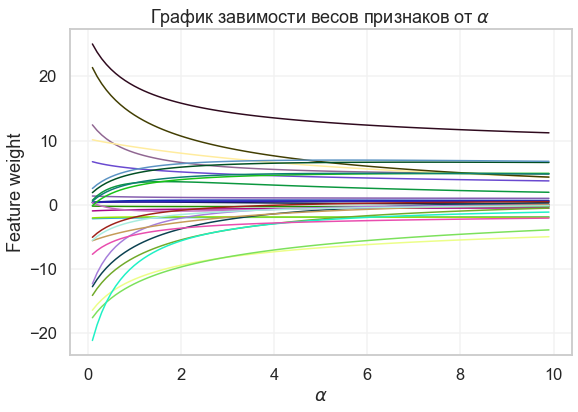

In [33]:
alphas = np.arange(0.1, 10, 0.1)
PLOT_L2_CV(X_oh, y_oh, cat_columns_oh, num_columns_oh, alphas, onehot = True, scaled = True, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_oh, y_oh, cat_columns_oh, num_columns_oh, alphas,\
                                    onehot = True, scaled = True, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

**Категориальные как порядковые**

The best alpha order:  1e+16
The best MSE:  682.47


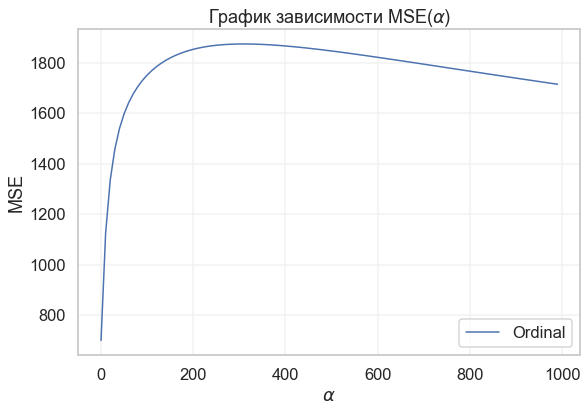

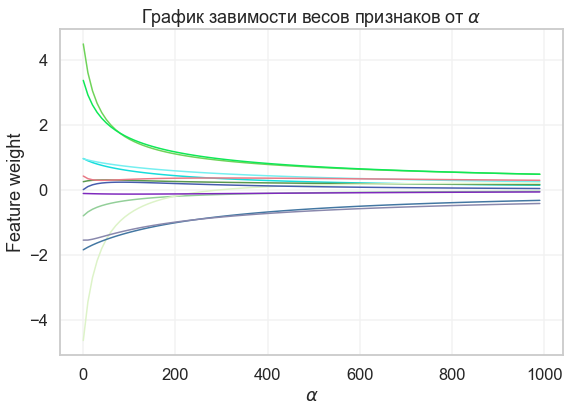

In [34]:
alphas = np.arange(0.1, 1000, 10)
PLOT_L2_CV(X, y, cat_columns, num_columns, alphas, onehot = False, scaled = True, n_splits = 10)

alphas = np.logspace(-16, 16, 33)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X, y, cat_columns, num_columns, alphas,\
                                    onehot = False, scaled = True, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

### 8. Отбор признаков

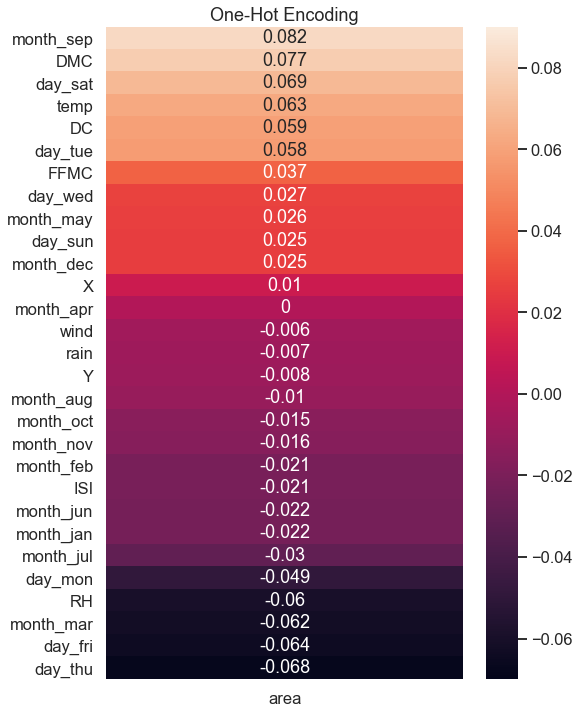

In [35]:
plt.figure(figsize = (8, 12))

sns.heatmap(pd.DataFrame(np.round(df_encoded_oh.corr()['area'].sort_values(ascending = False)[1:], 3)), vmin=-0.07, vmax=0.09, annot=True)
plt.title('One-Hot Encoding')
plt.savefig('features_corr_oh.pdf', bbox_inches = 'tight')

Топ 6 признаков, влияющих на целевую переменную: month_sep, DMC, day_sat, day_thu, day_fri, temp.

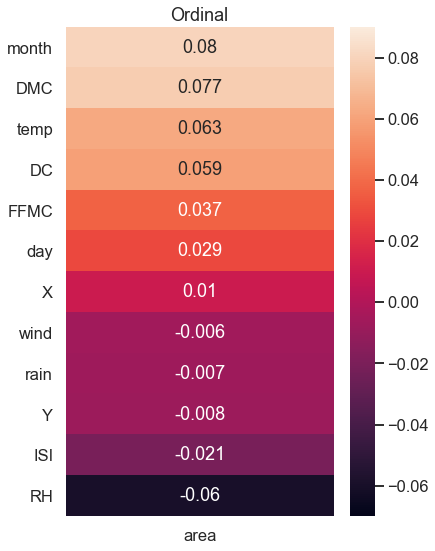

In [36]:
plt.figure(figsize = (6, 9))

sns.heatmap(pd.DataFrame(np.round(df_encoded.corr()['area'].sort_values(ascending = False)[1:], 3)), vmin=-0.07, vmax=0.09, annot=True)
plt.title('Ordinal')
plt.savefig('features_corr.pdf', bbox_inches = 'tight')

Топ 5 признаков, влияющих на целевую переменную: month, DMC, temp, RH, DC.

**Попробуем преобразовать признаки и отклики**

1. Преобразуем признак rain в категориальный

In [37]:
df_cut_1 = pd.DataFrame(df_cut.copy())

In [38]:
df_cut_1['rain'] = df_cut_1['rain'].apply(lambda x: int(x > 0))

2. Избавимся от объектов, для которых значение FFMC < 75. Таких всего 7.

In [39]:
df_cut_1 = df_cut_1[df_cut_1['FFMC'] >= 75]

3. Значения ISI сильно смещены в сторону нуля, поэтому рассмотрим в качестве нового признака ln(ISI)

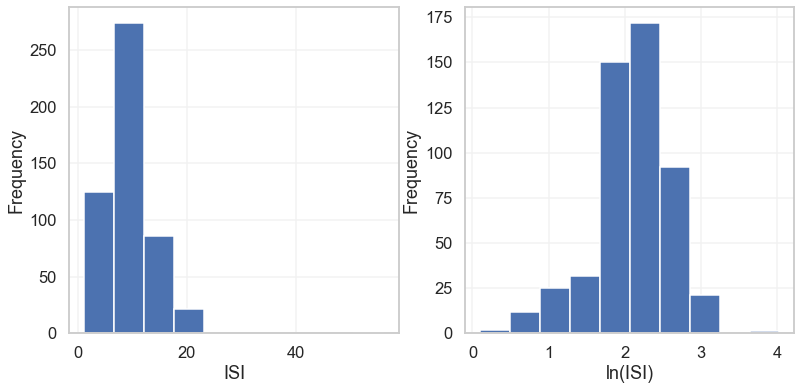

In [40]:
plt.figure(figsize = (13, 6))

plt.subplot(121)
df_cut_1['ISI'].plot.hist()
plt.xlabel("ISI")

plt.subplot(122)
np.log(df_cut_1['ISI']).plot.hist()
plt.xlabel("ln(ISI)");

In [41]:
df_cut_1['ISI'] = np.log(df_cut_1['ISI'])
df_cut_1.rename(columns = {'ISI': 'ln(ISI)'}, inplace = True)

4. Ну и наконец заметим, что распределение откликов очень уж смещено в сторону нуля, поэтому так же преобразуем их логарифмом. На этот раз ln(1 + x), поскольку большинство значений просто равны нулю.

Text(0.5, 0, 'ln(1 + area)')

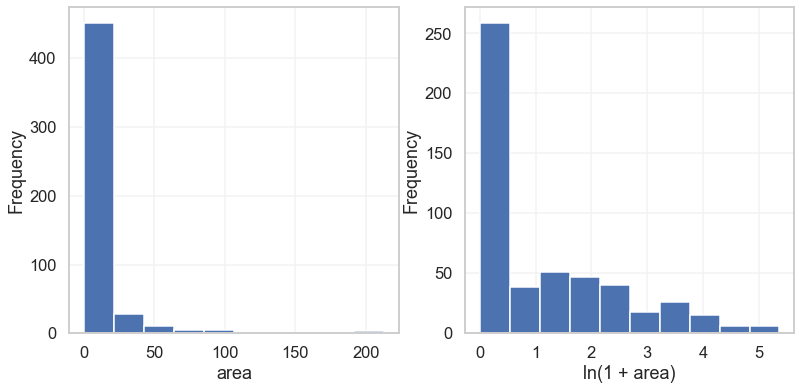

In [42]:
plt.figure(figsize = (13, 6))

plt.subplot(121)
df_cut_1['area'].plot.hist()
plt.xlabel("area")

plt.subplot(122)
np.log1p(df_cut_1['area']).plot.hist()
plt.xlabel("ln(1 + area)")

In [43]:
df_cut_1['area'] = np.log1p(df_cut_1['area'])
df_cut_1.rename(columns = {'area': 'ln(area)'}, inplace = True)

**Построим модель линейной регресии на новых данных**

In [44]:
cat_columns_1 = df_cut_1.select_dtypes(include = 'object').columns.tolist()
num_columns_1 = df_cut_1.select_dtypes(exclude = 'object').columns.tolist()

In [45]:
df_encoded_oh_1 = pd.get_dummies(df_cut_1, columns = cat_columns_1)

In [46]:
X_oh_1 = df_encoded_oh_1.drop(columns = 'ln(area)')
y_oh_1 = df_encoded_oh_1['ln(area)']

In [47]:
cat_columns_oh_1 = X_oh_1.select_dtypes(include = 'uint8').columns.tolist()
num_columns_oh_1 = X_oh_1.select_dtypes(exclude = 'uint8').columns.tolist()

In [48]:
df_encoded_1 = pd.DataFrame(df_cut_1.copy())

In [49]:
df_encoded_1['month'].replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'), (1,2,3,4,5,6,7,8,9,10,11,12), inplace = True)
df_encoded_1['day'].replace(('mon','tue','wed','thu','fri','sat','sun'), (1,2,3,4,5,6,7), inplace = True)

In [50]:
X_1 = df_encoded_1.drop(columns = 'ln(area)')
y_1 = df_encoded_1['ln(area)']

In [51]:
cat_columns_1 = df_cut_1.select_dtypes(include = 'object').columns.tolist()
num_columns_1 = X_1.select_dtypes(exclude = 'object').columns.tolist()

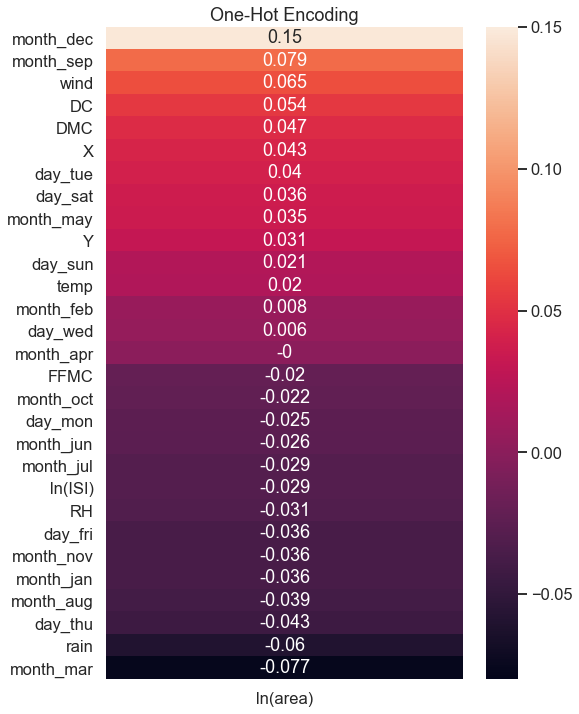

In [52]:
plt.figure(figsize = (8, 12))

sns.heatmap(pd.DataFrame(np.round(df_encoded_oh_1.corr()['ln(area)'].sort_values(ascending = False)[1:], 3)), vmin=-0.08, vmax=0.15, annot=True)
plt.title('One-Hot Encoding')
plt.savefig('features_corr_oh_1.pdf', bbox_inches = 'tight')

Топ 6 признаков, влияющих на целевую переменную: month_dec, month_sep, month_mar, wind, rain, DC, DMC.

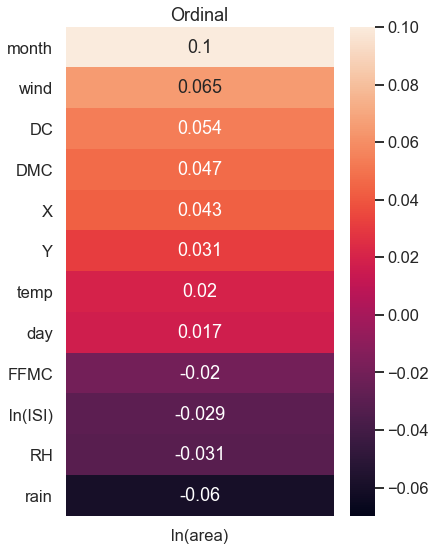

In [53]:
plt.figure(figsize = (6, 9))

sns.heatmap(pd.DataFrame(np.round(df_encoded_1.corr()['ln(area)'].sort_values(ascending = False)[1:], 3)), vmin=-0.07, vmax=0.1, annot=True)
plt.title('Ordinal')
plt.savefig('features_corr_1.pdf', bbox_inches = 'tight')

Топ 5 признаков, влияющих на целевую переменную: month, wind, rain, DC, DMC.

In [54]:
def w_opt(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def MSE(X, y, w):
    return (np.linalg.norm(X.dot(w) - y) ** 2) / X.shape[0]

def w_opt_reg(X, y, alpha):
    return np.linalg.inv(X.T.dot(X) + (alpha * np.identity(X.shape[1]))).dot(X.T).dot(y)

def MSE_reg(X, y, w, alpha):
    return ((np.linalg.norm(X.dot(w) - y) ** 2) / X.shape[0]) + (alpha * (np.linalg.norm(w) ** 2))

In [55]:
print('One-Hot encoding:')
print('MSE =', round(MSE(X_oh_1, y_oh_1, w_opt(X_oh_1, y_oh_1)), 2))
print('RMSE =', round(np.sqrt(MSE(X_oh_1, y_oh_1, w_opt(X_oh_1, y_oh_1))), 2))

One-Hot encoding:
MSE = 16.77
RMSE = 4.1


In [56]:
print('Категориальные как порядковые:')
print('MSE =', round(MSE(X_1, y_1, w_opt(X_1, y_1)), 2))
print('RMSE =', round(np.sqrt(MSE(X_1, y_1, w_opt(X_1, y_1))), 2))

Категориальные как порядковые:
MSE = 1.74
RMSE = 1.32


In [57]:
print('One-Hot encoding, alpha = 1:')
print('MSE =', round(MSE_reg(X_oh_1, y_oh_1, w_opt_reg(X_oh_1, y_oh_1, 1), 1), 2))
print('RMSE =', round(np.sqrt(MSE_reg(X_oh_1, y_oh_1, w_opt_reg(X_oh_1, y_oh_1, 1), 1)), 2))

One-Hot encoding, alpha = 1:
MSE = 6.42
RMSE = 2.53


In [58]:
print('Категориальные как порядковые, alpha = 1:')
print('MSE =', round(MSE_reg(X_1, y_1, w_opt_reg(X_1, y_1, 1), 1), 2))
print('RMSE =', round(np.sqrt(MSE_reg(X_1, y_1, w_opt_reg(X_1, y_1, 1), 1)), 2))

Категориальные как порядковые, alpha = 1:
MSE = 2.22
RMSE = 1.49


In [59]:
# Строит графики зависимостей MSE(alpha) и W(alpha)
def PLOT_L2_CV(X, y, cat_columns, num_columns, alphas, onehot = True, scaled = False, n_splits = 5):
    
    MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X, y, cat_columns, num_columns, alphas, onehot, scaled, n_splits)
    
    plt.figure(figsize = (9, 6))
    
    label = onehot * 'One-Hot Encoding' + (1 - onehot) * 'Ordinal'
    plt.plot(alphas, MSEs, label = label)
    plt.title('График зависимости MSE($\\alpha$)')
    plt.xlabel('$\\alpha$')
    plt.ylabel('MSE')
    plt.legend(loc = 'lower right')
    
    plt.savefig('MSE_plot' + onehot * '_oh' + scaled * '_scaled' + '_1.pdf', bbox_inches = 'tight')
    
    plt.figure(figsize = (9, 6))

    for coef, feature in zip(np.array(Ws).T, X.columns):
        plt.plot(alphas, coef, label = feature, color = np.random.rand(3))
    
    plt.title('График завимости весов признаков от $\\alpha$')
    plt.xlabel("$\\alpha$")
    plt.ylabel("Feature weight")
    
    plt.savefig('feature_plot' + onehot * '_oh' + scaled * '_scaled' + '_1.pdf', bbox_inches = 'tight')

**One-Hot encoding**

The best alpha order:  1e-12
The best MSE:  1.9


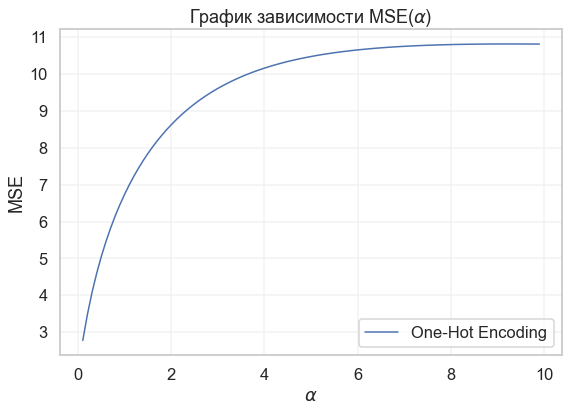

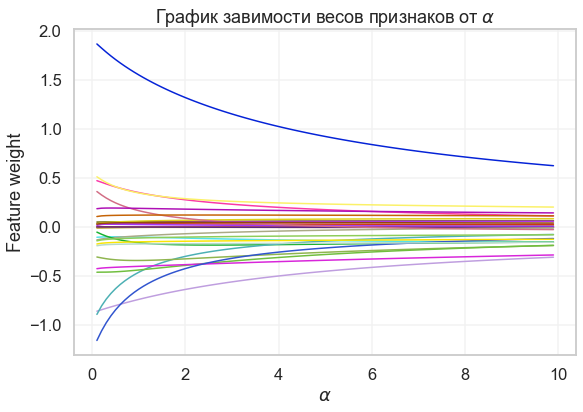

In [60]:
alphas = np.arange(0.1, 10, 0.1)
PLOT_L2_CV(X_oh_1, y_oh_1, cat_columns_oh_1, num_columns_oh_1, alphas, onehot = True, scaled = False, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_oh_1, y_oh_1, cat_columns_oh_1, num_columns_oh_1, alphas,\
                                    onehot = True, scaled = False, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

**Категориальные как порядковые**

The best alpha order:  1e-12
The best MSE:  1.82


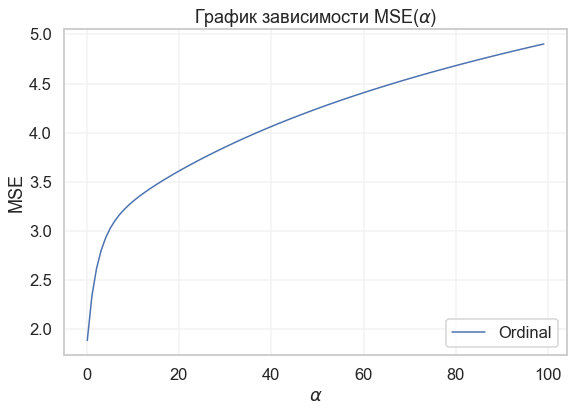

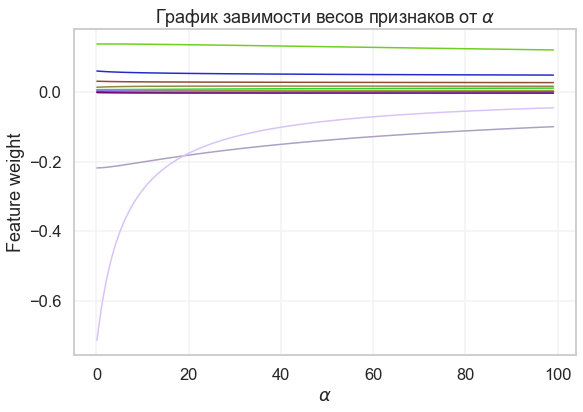

In [61]:
alphas = np.arange(0.1, 100, 1)
PLOT_L2_CV(X_1, y_1, cat_columns_1, num_columns_1, alphas, onehot = False, scaled = False, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_1, y_1, cat_columns_1, num_columns_1, alphas,\
                                    onehot = False, scaled = False, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

**При стандартизации**

**One-Hot encoding**

The best alpha order:  1e-11
The best MSE:  1.89


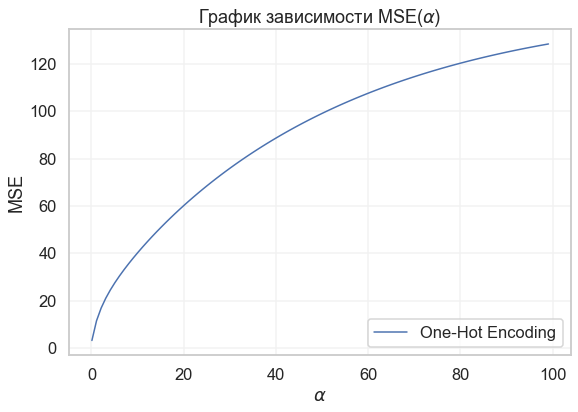

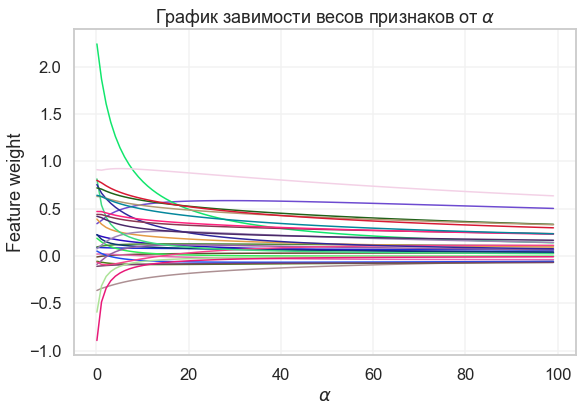

In [62]:
alphas = np.arange(0.1, 100, 1)
PLOT_L2_CV(X_oh_1, y_oh_1, cat_columns_oh_1, num_columns_oh_1, alphas, onehot = True, scaled = True, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_oh_1, y_oh_1, cat_columns_oh_1, num_columns_oh_1, alphas,\
                                    onehot = True, scaled = True, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

**Категориальные как порядковые**

The best alpha order:  1000000000000.0
The best MSE:  2.99


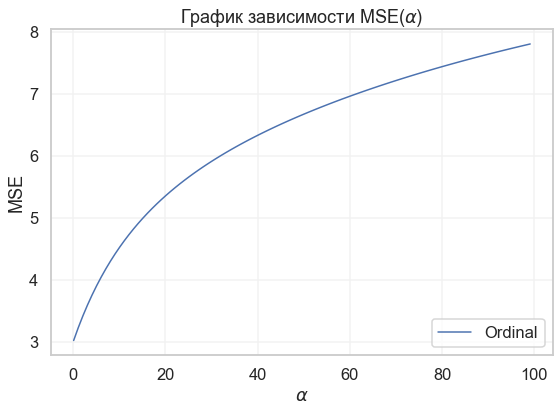

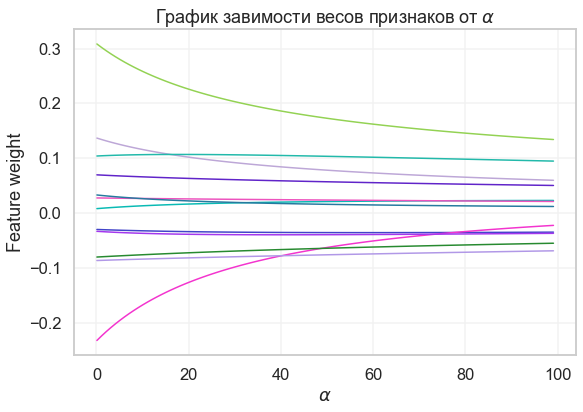

In [63]:
alphas = np.arange(0.1, 100, 1)
PLOT_L2_CV(X_1, y_1, cat_columns_1, num_columns_1, alphas, onehot = False, scaled = True, n_splits = 10)

alphas = np.logspace(-12, 12, 25)
MSEs, Ws, Alpha, MSE, W = MSE_L2_CV(X_1, y_1, cat_columns_1, num_columns_1, alphas,\
                                    onehot = False, scaled = True, n_splits = 10)

print('The best alpha order: ', Alpha)
print('The best MSE: ', np.round(MSE, 2))

### 9. Другие модели

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

а) Решающее дерево

In [65]:
decision_tree = DecisionTreeRegressor()

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_oh, y_oh, test_size = 0.25, random_state = 37)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print('One-Hot encoding:')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 37)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print('\nOrdinal:')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_oh_1, y_oh_1, test_size = 0.25, random_state = 37)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print('\nOne-Hot encoding (my features):')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.25, random_state = 37)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print('\nOrdinal (my features):')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

One-Hot encoding:
MSE = 1373.1417405038758
RMSE = 37.05592719800539

Ordinal:
MSE = 1406.6516296511627
RMSE = 37.50535467971424

One-Hot encoding (my features):
MSE = 3.7508050400964192
RMSE = 1.9366995224082695

Ordinal (my features):
MSE = 3.6749196492823124
RMSE = 1.9170079940580091


б) Случайный лес

In [66]:
random_forest = RandomForestRegressor()

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_oh, y_oh, test_size = 0.25, random_state = 37)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print('One-Hot encoding:')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 37)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print('\nOrdinal:')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_oh_1, y_oh_1, test_size = 0.25, random_state = 37)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print('\nOne-Hot encoding (my features):')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

#----------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size = 0.25, random_state = 37)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print('\nOrdinal (my features):')
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', mean_squared_error(y_test, y_pred, squared = False))

One-Hot encoding:
MSE = 1129.2302767416313
RMSE = 33.60402173463217

Ordinal:
MSE = 1085.6347773139178
RMSE = 32.94897232561158

One-Hot encoding (my features):
MSE = 2.3004942474401804
RMSE = 1.5167380286127794

Ordinal (my features):
MSE = 2.3018712343055294
RMSE = 1.5171918910624091
